In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pruned_ft_df = pd.read_json(
    "/gscratch/scrubbed/clin25/diffusion-attr/seed42/artbench_post_impressionism/pruned_ft_ratio_lr_lora_steps.jsonl",
    lines=True,
)
num_steps_per_epoch = 79
n_samples = 50

In [3]:
pruned_ft_df["ratio"] = (
    pruned_ft_df["exp_name"]
    .str.split("/", expand=True)[4]
    .str.split("=", expand=True)[1]
    .astype(float)
)
pruned_ft_df["lr"] = (
    pruned_ft_df["exp_name"]
    .str.split("/", expand=True)[5]
    .str.split("=", expand=True)[1]
    .astype(float)
)
pruned_ft_df["steps"] = (
    pruned_ft_df["exp_name"]
    .str.split("/", expand=True)[6]
    .str.split("=", expand=True)[1]
    .astype(int)
)
pruned_ft_df["epochs"] = pruned_ft_df["steps"] / num_steps_per_epoch

ratio_list = pruned_ft_df["ratio"].unique().tolist()
lr_list = pruned_ft_df["lr"].unique().tolist()
epochs_list = pruned_ft_df["epochs"].unique().tolist()
ratio_list = sorted(ratio_list)
lr_list = sorted(lr_list)
epochs_list = sorted(epochs_list)

In [4]:
ssim_cols = [f"generated_image_{i}_ssim" for i in range(n_samples)]
aesthetic_score_time_col = "aesthetic_score_time"

In [5]:
optimal_ratio, optimal_lr, optimal_epochs = None, None, None
optimal_ssim = 0
for ratio in ratio_list:
    for lr in lr_list:
        for epochs in epochs_list:
            df = pruned_ft_df[pruned_ft_df["ratio"] == ratio]
            df = df[df["lr"] == lr]
            df = df[df["epochs"] == epochs]
            ssim = df[ssim_cols].mean(axis=1).item()
            if ssim > optimal_ssim:
                optimal_ratio = ratio
                optimal_lr = lr
                optimal_epochs = epochs
                optimal_ssim = ssim

print(f"Optimal average SSIM={optimal_ssim}")
print(f"Optimal ratio={optimal_ratio}")
print(f"Optimal lr={optimal_lr}")
print(f"Optimal epochs={optimal_epochs}")

Optimal average SSIM=0.9367773137887412
Optimal ratio=0.9
Optimal lr=1e-06
Optimal epochs=20.0


In [6]:
ratio_ssim_dict = {}
for ratio in ratio_list:
    df = pruned_ft_df[(pruned_ft_df["ratio"] == ratio) & (pruned_ft_df["lr"] == optimal_lr)]
    df = df.sort_values("epochs", ascending=True)
    ratio_ssim_dict[ratio] = {
        epochs: df[ssim_cols].mean(axis=1).to_list()[i]
        for i, epochs in enumerate(epochs_list)
    }

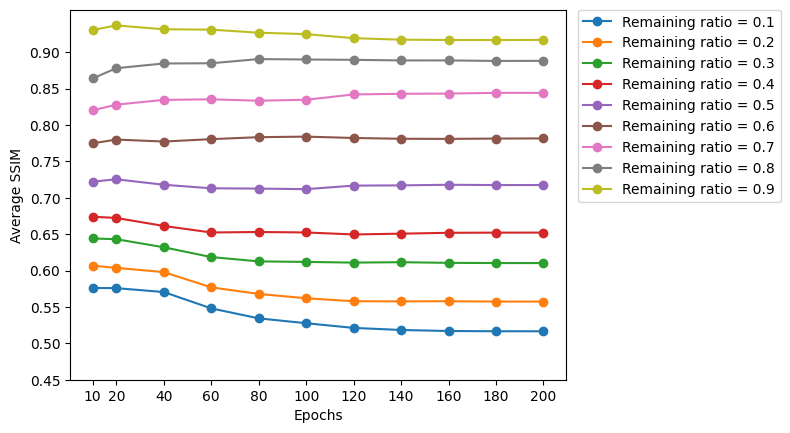

In [7]:
for ratio in ratio_list:
    ssim_list = [ratio_ssim_dict[ratio][epochs] for epochs in epochs_list]
    plt.plot(epochs_list, ssim_list, marker="o", label=f"Remaining ratio = {ratio}")
plt.xticks(epochs_list)
plt.yticks([0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])
plt.xlabel("Epochs")
plt.ylabel("Average SSIM")
plt.legend(bbox_to_anchor=(1.01, 1.02))
plt.show()